In [58]:
import numpy as np

from keplergl import KeplerGl

import pandas as pd
from pandas.api.types import CategoricalDtype

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import linear_model as lm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler

plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 12
sns.set()

In [33]:
df = pd.read_table("earthquakes-2023.tsv",sep='\t')
# the below .drop() lines remove empty row and column 0 and 0 that the data source provides with the dataset
# to represent the search parameters used. Because we retrieved all the available data, these are only NaN
# values and thus irrelevant.
df = df.drop(['Search Parameters'], axis=1)
df = df.drop(index=0, axis=0)
display(df)

,Year,Mo,Dy,Hr,Mn,Sec,Tsu,Vol,Location Name,Latitude,...,Total Missing,Total Missing Description,Total Injuries,Total Injuries Description,Total Damage ($Mil),Total Damage Description,Total Houses Destroyed,Total Houses Destroyed Description,Total Houses Damaged,Total Houses Damaged Description
1,-2150.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,"JORDAN: BAB-A-DARAA,AL-KARAK",31.100,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-2000.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,SYRIA: UGARIT,35.683,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-2000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TURKMENISTAN: W,38.000,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN
4,-1610.0,NaN,NaN,NaN,NaN,NaN,3.0,1351.0,GREECE: THERA ISLAND (SANTORINI),36.400,...,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN
5,-1566.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,ISRAEL: ARIHA (JERICHO),31.500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6347,2023.0,2.0,6.0,1.0,17.0,35.0,5873.0,NaN,TURKEY; SYRIA,37.166,...,NaN,NaN,118300.0,4.0,34200.0,4.0,174321.0,4.0,NaN,4.0
6348,2023.0,2.0,6.0,10.0,24.0,49.0,NaN,NaN,TURKEY; SYRIA,38.024,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6349,2023.0,2.0,9.0,6.0,28.0,0.0,NaN,NaN,INDONESIA: NEW GUINEA: IRIAN JAYA: JAYAPURA,-2.635,...,NaN,NaN,NaN,NaN,NaN,1.0,15.0,1.0,28.0,1.0
6350,2023.0,2.0,20.0,17.0,4.0,29.0,NaN,NaN,TURKEY; SYRIA,36.109,...,NaN,NaN,200.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN


We have the dataset containing 6351 rows and 38 columns loaded, looking at the .head() of the dataset it seems that there are **a lot** of missing values, but lets check this with the code below:

In [34]:
# the below code prints the percentage of values in each column that = NaN
nan_percentages = df.isna().mean()*100
print(nan_percentages)

Year                                   0.000000
Mo                                     6.439931
Dy                                     8.911982
Hr                                    32.278381
Mn                                    35.490474
Sec                                   31.522595
Tsu                                   69.122973
Vol                                   98.787593
Location Name                          0.015746
Latitude                               0.818769
Longitude                              0.818769
Focal Depth (km)                      46.717052
Mag                                   27.964100
MMI Int                               51.739883
Deaths                                66.430483
Death Description                     58.809636
Missing                               99.606361
Missing Description                   99.606361
Injuries                              78.712014
Injuries Description                  75.185010
Damage ($Mil)                         91

The above sadly confirms the suspicion that most of the columns contain a lot of NaN values. This will prove to be an issue later on in our project.

In [39]:
# set the 'Total ...' column's value for each observation equal to the '...' column for that observation if 
# the 'Total ...' column is 0 or NaN. This makes it such that all deaths/injuries etc. are fully represented
# in the 'Total ...' columns.
# We can do this because for our analysis we consider tsunami/vulcano caused deaths to also be earthquakes caused 
# deaths if that tsunami/volcano was caused by an earthquake.
df.loc[df['Total Deaths'].isna() | (df['Total Deaths'] == 0), 'Total Deaths'] = df['Deaths']
df.loc[df['Total Missing'].isna() | (df['Total Missing'] == 0), 'Total Missing'] = df['Missing']
df.loc[df['Total Injuries'].isna() | (df['Total Injuries'] == 0), 'Total Injuries'] = df['Injuries']
df.loc[df['Total Damage ($Mil)'].isna() | (df['Total Damage ($Mil)'] == 0), 'Total Damage ($Mil)'] = df['Damage ($Mil)']
df.loc[df['Total Houses Destroyed'].isna() | (df['Total Houses Destroyed'] == 0), 'Total Houses Destroyed'] = df['Houses Destroyed']
df.loc[df['Total Houses Damaged'].isna() | (df['Total Houses Damaged'] == 0), 'Total Houses Damaged'] = df['Houses Damaged']

In [40]:
# lets print the NaN percentages again to see how much we improved
nan_percentages = df.isna().mean()*100
print(nan_percentages)

Year                                   0.000000
Mo                                     6.439931
Dy                                     8.911982
Hr                                    32.278381
Mn                                    35.490474
Sec                                   31.522595
Tsu                                   69.122973
Vol                                   98.787593
Location Name                          0.015746
Latitude                               0.818769
Longitude                              0.818769
Focal Depth (km)                      46.717052
Mag                                   27.964100
MMI Int                               51.739883
Deaths                                66.430483
Death Description                     58.809636
Missing                               99.606361
Missing Description                   99.606361
Injuries                              78.712014
Injuries Description                  75.185010
Damage ($Mil)                         91

In [48]:
# create copy of preprocessed dataframe to use in later regression model
df_c = df.copy()

Comparing the above NaN percentages to the earlier ones we can see that there is definitely an improvement. For example, the amount of NaN values in the 'Total Deaths' feature decreased from ~69% to ~64%.

In [11]:
# Geospacial plots

# create a new dataframe with 'Latitude', 'Longitude', 'Mag', 'Location Name'
df_seismic = df[['Latitude', 'Longitude', 'Mag', 'Location Name']]
# remove all columns with NaN values
df_seismic = df_seismic.dropna()
display(df_seismic)

,Latitude,Longitude,Mag,Location Name
1,31.100,35.500,7.3,"JORDAN: BAB-A-DARAA,AL-KARAK"
3,38.000,58.200,7.1,TURKMENISTAN: W
8,32.000,35.500,6.5,ISRAEL: ARIHA (JERICHO)
9,29.600,35.000,6.2,JORDAN: SW: TIMNA COPPER MINES
15,39.700,23.300,7.0,GREECE: MACEDONIA
...,...,...,...,...
6347,37.166,37.042,7.8,TURKEY; SYRIA
6348,38.024,37.203,7.5,TURKEY; SYRIA
6349,-2.635,140.557,5.1,INDONESIA: NEW GUINEA: IRIAN JAYA: JAYAPURA
6350,36.109,36.017,6.3,TURKEY; SYRIA


In [12]:
map = KeplerGl(height=600)
map.add_data(data=df_seismic, name='seismic')

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


In [13]:
map.save_to_html(file_name='seismic.html')

Map saved to seismic.html!


In [14]:
print(df.columns)

Index(['Search Parameters', 'Year', 'Mo', 'Dy', 'Hr', 'Mn', 'Sec', 'Tsu',
       'Vol', 'Location Name', 'Latitude', 'Longitude', 'Focal Depth (km)',
       'Mag', 'MMI Int', 'Deaths', 'Death Description', 'Missing',
       'Missing Description', 'Injuries', 'Injuries Description',
       'Damage ($Mil)', 'Damage Description', 'Houses Destroyed',
       'Houses Destroyed Description', 'Houses Damaged',
       'Houses Damaged Description', 'Total Deaths', 'Total Death Description',
       'Total Missing', 'Total Missing Description', 'Total Injuries',
       'Total Injuries Description', 'Total Damage ($Mil)',
       'Total Damage Description', 'Total Houses Destroyed',
       'Total Houses Destroyed Description', 'Total Houses Damaged',
       'Total Houses Damaged Description'],
      dtype='object')


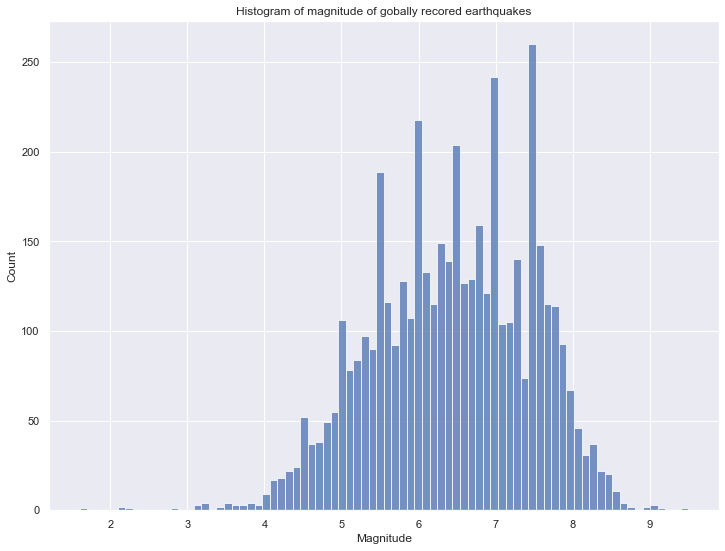

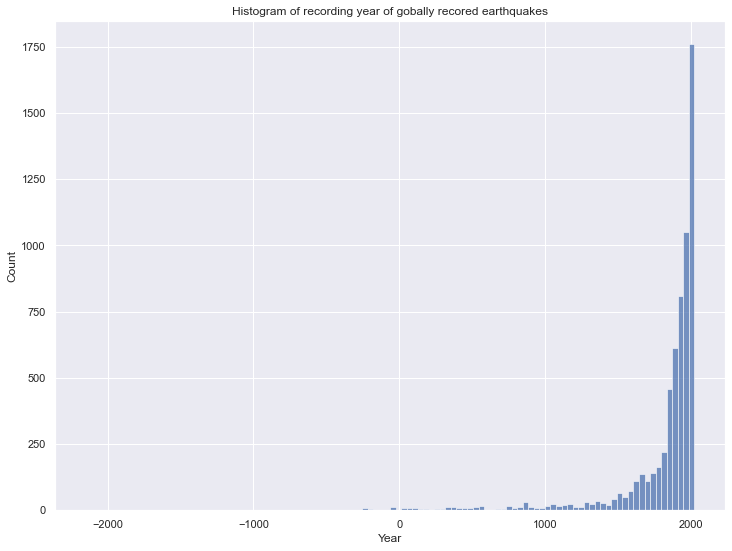

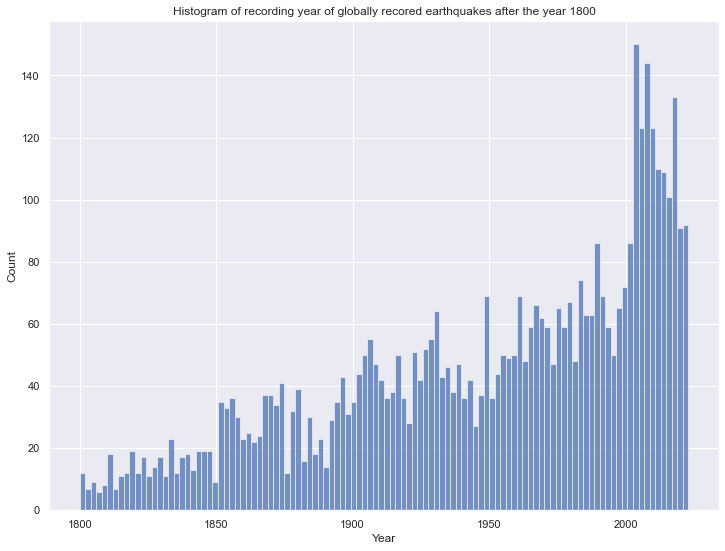

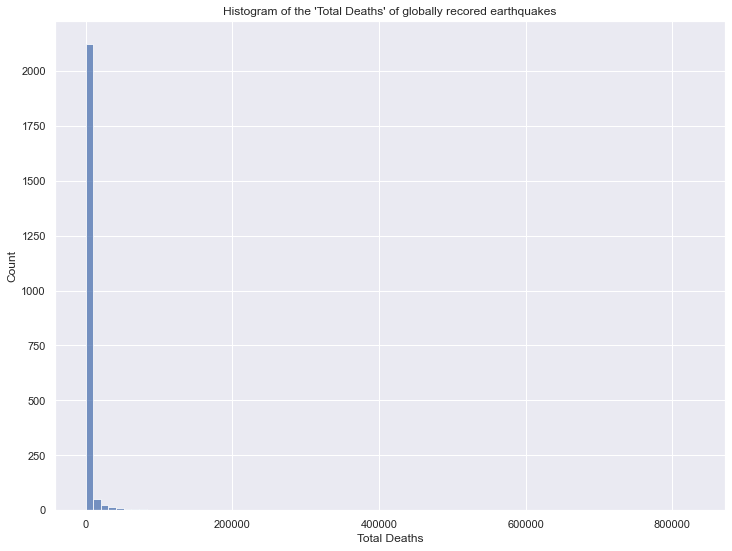

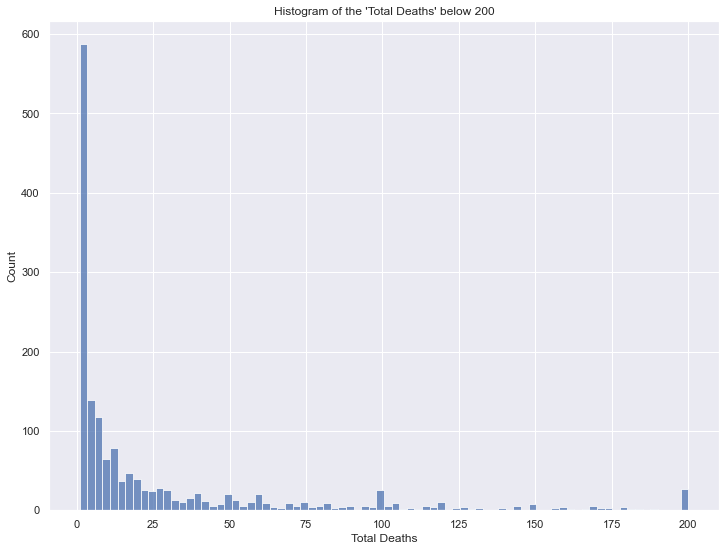

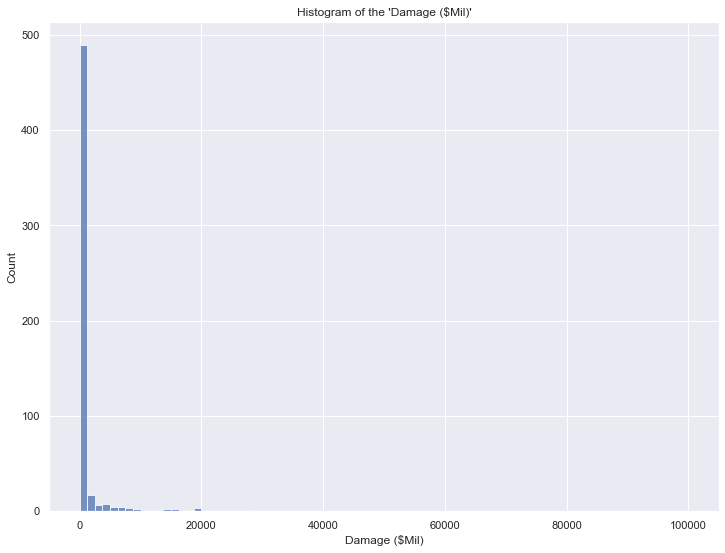

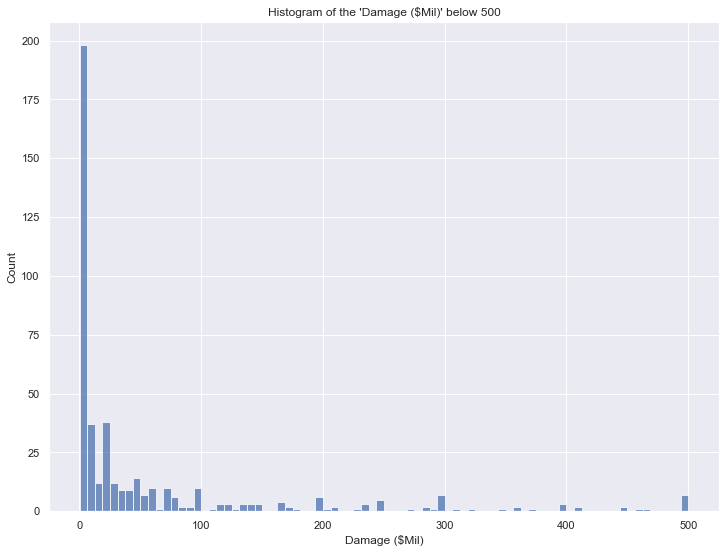

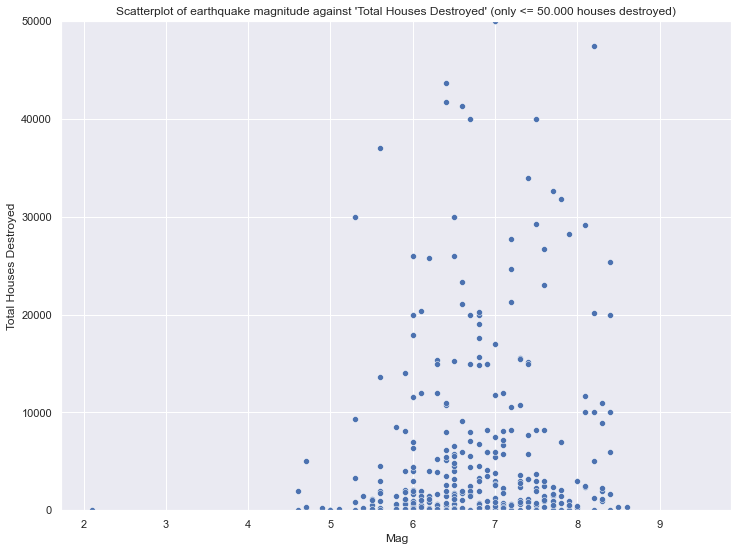

In [42]:
# Below we show some general histograms for our data to look at the distribution in it.

plt.figure()
sns.histplot(df['Mag'], bins=80)
plt.xlabel('Magnitude')
plt.title('Histogram of magnitude of gobally recored earthquakes')
plt.show()

plt.figure()
sns.histplot(df['Year'], bins=110)
plt.title('Histogram of recording year of gobally recored earthquakes')
plt.show()

# because the above plot is very right skewed, we show the same plot here but with only values >= 1800.
# these values will also be more relevant for our prediction models.
plt.figure()
sns.histplot(df.loc[df['Year'] >= 1800, 'Year'], bins=110)
plt.title('Histogram of recording year of globally recored earthquakes after the year 1800')
plt.show()

plt.figure()
sns.histplot(df['Total Deaths'], bins=80)
plt.title('Histogram of the \'Total Deaths\' of globally recored earthquakes')
plt.show()

# because the above plot is very left skewed, we show the same plot here but with only values <= 200
plt.figure()
sns.histplot(df.loc[df['Total Deaths'] <= 200, 'Total Deaths'], bins=80)
plt.title('Histogram of the \'Total Deaths\' below 200')
plt.show()

plt.figure()
sns.histplot(df['Damage ($Mil)'], bins=80)
plt.title('Histogram of the \'Damage ($Mil)\'')
plt.show()

# because the above plot is very left skewed, we show the same plot here but with only values <= 500
plt.figure()
sns.histplot(df.loc[df['Damage ($Mil)'] <= 500, 'Damage ($Mil)'], bins=80)
plt.title('Histogram of the \'Damage ($Mil)\' below 500')
plt.show()


# the below scatterplot shows magnitude against total houses destroyed to see if there is a correlation
# visually present here. Sadly the plot doesn't seem to give us a lot of information.
df_only_deaths = df[df['Total Deaths'] >= 10]
plt.figure()
sns.scatterplot(data=df_only_deaths, x='Mag', y='Total Houses Destroyed')
plt.ylim(0, 50000)
plt.title('Scatterplot of earthquake magnitude against \'Total Houses Destroyed\' (only <= 50.000 houses destroyed)')
plt.show()

In [28]:
# Correlation checks

# check all column correlations and save the one with highest correlation
cor = df.corr().abs().unstack().sort_values(ascending=False).drop_duplicates()
# show all entries with correlation > 0.5
cor[cor > 0.5].head(60)
#Total Houses Damaged                Injuries 0.980400 correlation

Year                                Year                                  1.000000
Total Missing                       Missing                               0.999999
Houses Destroyed                    Total Houses Destroyed                0.998884
Missing                             Total Deaths                          0.997842
                                    Deaths                                0.997840
Total Deaths                        Total Missing                         0.997336
Total Missing                       Deaths                                0.996844
Houses Damaged                      Houses Destroyed                      0.996509
Total Houses Destroyed              Houses Damaged                        0.996338
Total Houses Damaged                Total Houses Destroyed                0.996114
                                    Houses Destroyed                      0.996062
Injuries Description                Total Injuries Description            0.995341
Hous

total countries in dataframe:  266
country with most recorded earthquakes:  CHINA    586
Name: Country, dtype: int64


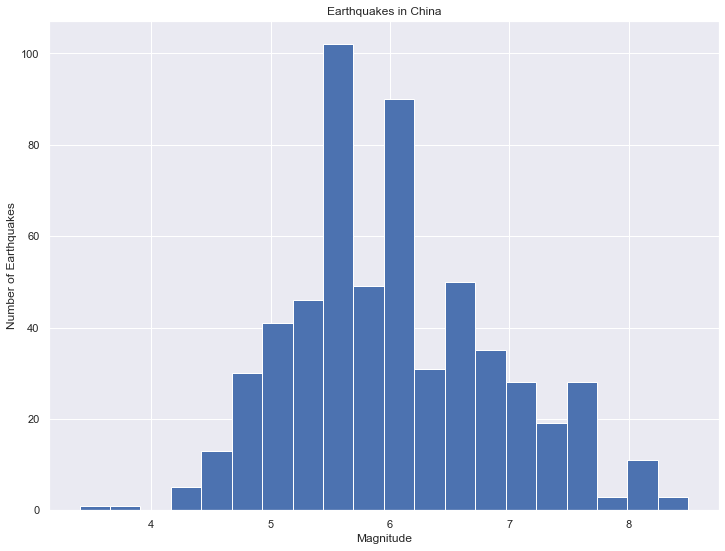

In [22]:
# Histograms of magnitude

# make a new column called 'Country' taking the part of the string in 'Location Name'
# before the first colon or before the first semi-colon
df['Country'] = df['Location Name'].str.split(':|;', expand=True)[0]
# make a new dataframe with 'Country' and 'Mag'
df_country = df[['Country', 'Mag']]
# remove all columns with NaN values
df_country = df_country.dropna()
# find how many countries are in the dataframe
print("total countries in dataframe: ", df_country['Country'].nunique())
# find which country appears the most and the number of times it happens
print("country with most recorded earthquakes: ", df_country['Country'].value_counts().head(1))
# make a new data frame for the country with the most earthquakes
df_country_most = df_country[df_country['Country'] == 'CHINA']
# make a histogram having 'Mag' on the x-axis and the number of earthquakes on the y-axis
df_country_most['Mag'].hist(bins=20)
plt.xlabel('Magnitude')
plt.ylabel('Number of Earthquakes')
plt.title('Earthquakes in China')
plt.show()

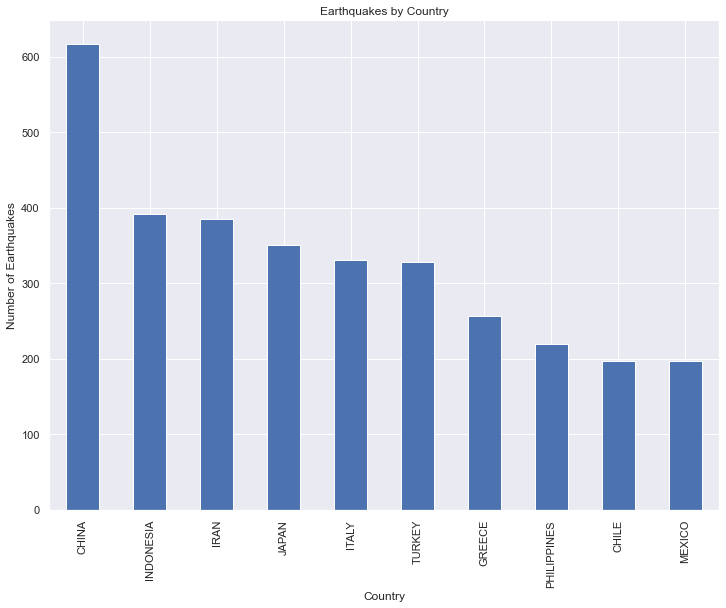

In [24]:
# make a plot of earthquake amount by country
df['Country'].value_counts().head(10).plot(kind='bar')
plt.xlabel('Country')
plt.ylabel('Number of Earthquakes')
plt.title('Earthquakes by Country')
plt.show()

In [25]:
## Average MAG by Country
# get average 'Mag' for each country by joining rows of same country name
df_country_mean = df_country.groupby('Country').mean()
# sort the dataframe by 'Mag' in descending order
df_country_mean = df_country_mean.sort_values(by='Mag', ascending=False)
display(df_country_mean)

,Mag
Country,
CASCADIA SUBDUCTION ZONE,9.000000
INDIA-CHINA,8.250000
BOLIVIA-PERU,8.200000
MACQUARIE ISLAND,8.200000
BALLENY ISLANDS,8.100000
...,...
CZECH REPUBLIC,4.100000
THE NETHERLANDS,3.933333
POLAND,3.800000


C:\Users\SiBuX\AppData\Local\Temp\ipykernel_23912\3324443581.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_country['Continent'] = df_country['Country'].map(df_continent.set_index('Country')['Continent'])


Text(0.5, 0.98, 'Earthquake Magnitude by Continent')

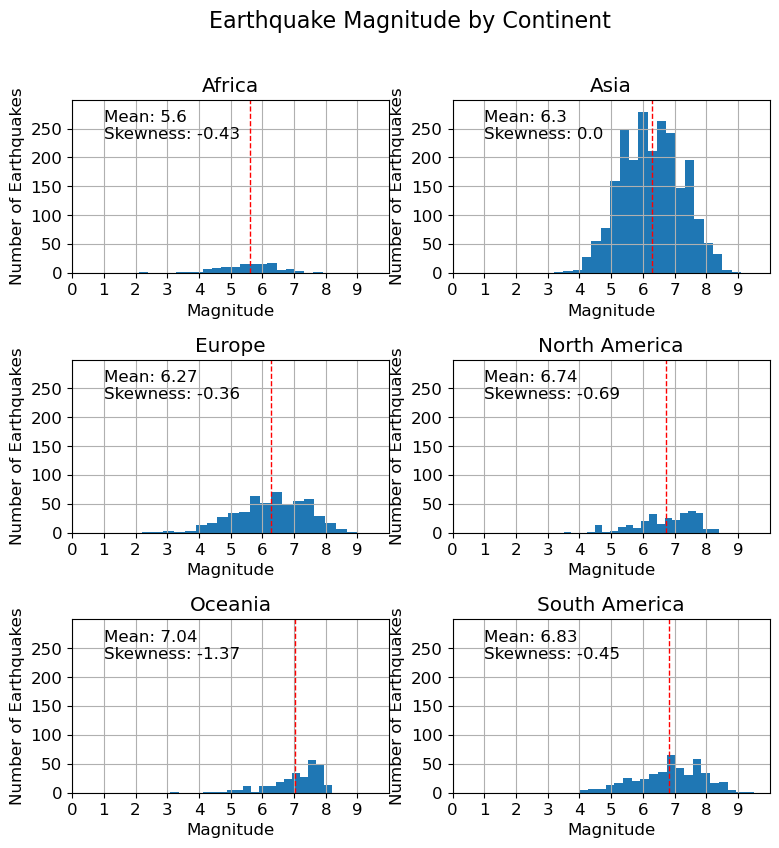

In [54]:
# split up location to get country
df['Country'] = df['Location Name'].str.split(':|;', expand=True)[0]
# get only the country and magnitude columns
df_country = df[['Country', 'Mag']]
# read the continent data that just has simple mappings of country to continent
df_continent = pd.read_excel('continents.xlsx')
# make the country names uppercase to match the other dataframe
df_continent['Country'] = df_continent['Country'].str.upper()
# add a new column to the country dataframe called 'Continent' and map the country names to the continent names
df_country['Continent'] = df_country['Country'].map(df_continent.set_index('Country')['Continent'])
# drop all rows with NaN values
df_country = df_country.dropna()
# make a list of dataframes for each continent
df_continents = [df_country[df_country['Continent'] == 'Africa'],
                    df_country[df_country['Continent'] == 'Asia'],
                    df_country[df_country['Continent'] == 'Europe'],
                    df_country[df_country['Continent'] == 'North America'],
                    df_country[df_country['Continent'] == 'Oceania'],
                    df_country[df_country['Continent'] == 'South America']]
# make a histogram for each continent, 6 in total
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(9, 9))
for i, ax in enumerate(axes.flatten()):
    df_continents[i]['Mag'].hist(bins=20, ax=ax)
    ax.set_title(df_continents[i]['Continent'].unique()[0])
    ax.set_xlim(0, 10)
    ax.set_xticks(np.arange(0, 10, 1))
    ax.set_ylim(0, 300)
    ax.set_yticks(np.arange(0, 300, 50))
    ax.set_xlabel('Magnitude')
    ax.set_ylabel('Number of Earthquakes')
    fig.subplots_adjust(hspace=0.5)
    # add mean and skewness to each plot
    ax.text(0.1, 0.9, 'Mean: ' + str(round(df_continents[i]['Mag'].mean(), 2)),
            horizontalalignment='left',
            verticalalignment='center',
            transform=ax.transAxes)
    # add mean line to each plot
    ax.axvline(df_continents[i]['Mag'].mean(), color='r', linestyle='dashed', linewidth=1)
    ax.text(0.1, 0.8, 'Skewness: ' + str(round(df_continents[i]['Mag'].skew(), 2)),
            horizontalalignment='left',
            verticalalignment='center',
            transform=ax.transAxes)
fig.suptitle('Earthquake Magnitude by Continent', fontsize=16)
#fig.savefig('earthquake_magnitude_by_continent.png')

,Country,Mag,Year,Density
4,JORDAN,5.3,2004,62.697450
14,TURKMENISTAN,4.6,1983,6.558853
15,TURKMENISTAN,7.0,2000,9.723006
209,GREECE,6.3,1965,66.333072
210,GREECE,7.1,1965,66.333072
...,...,...,...,...
4375,MOZAMBIQUE,5.6,2017,36.330325
4376,MOZAMBIQUE,5.6,2018,37.416870
4377,MADAGASCAR,5.5,2017,44.980306
4378,ZAMBIA,5.9,2017,23.269151


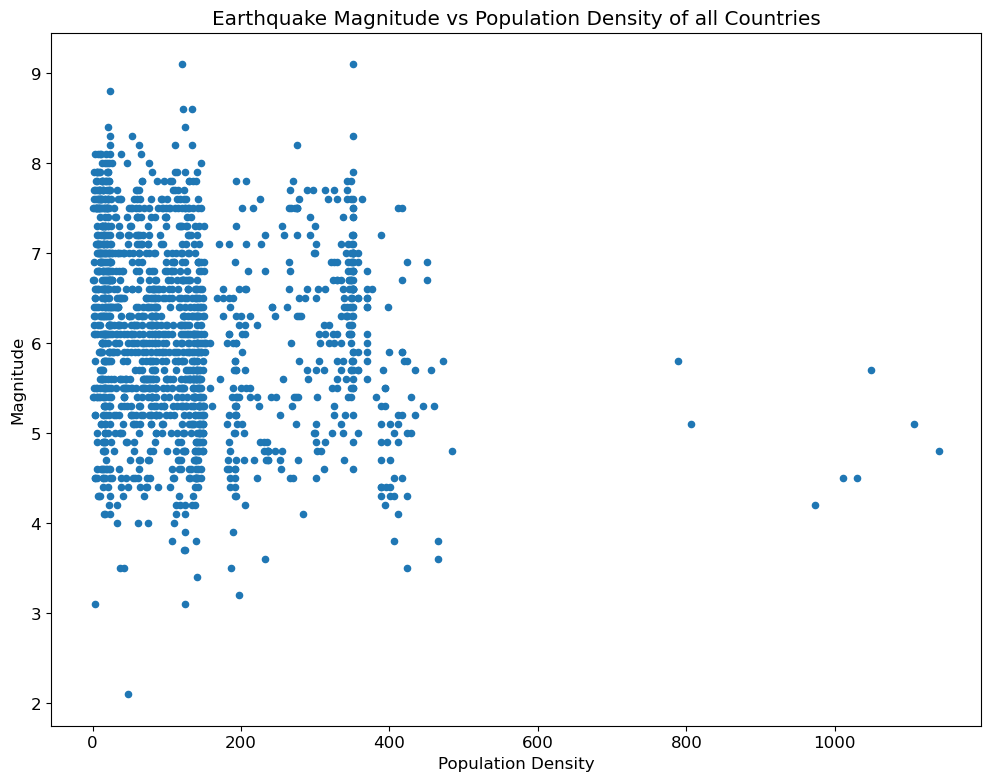

Text(0.5, 0.98, 'Earthquake Magnitude vs Population Density by Continent')

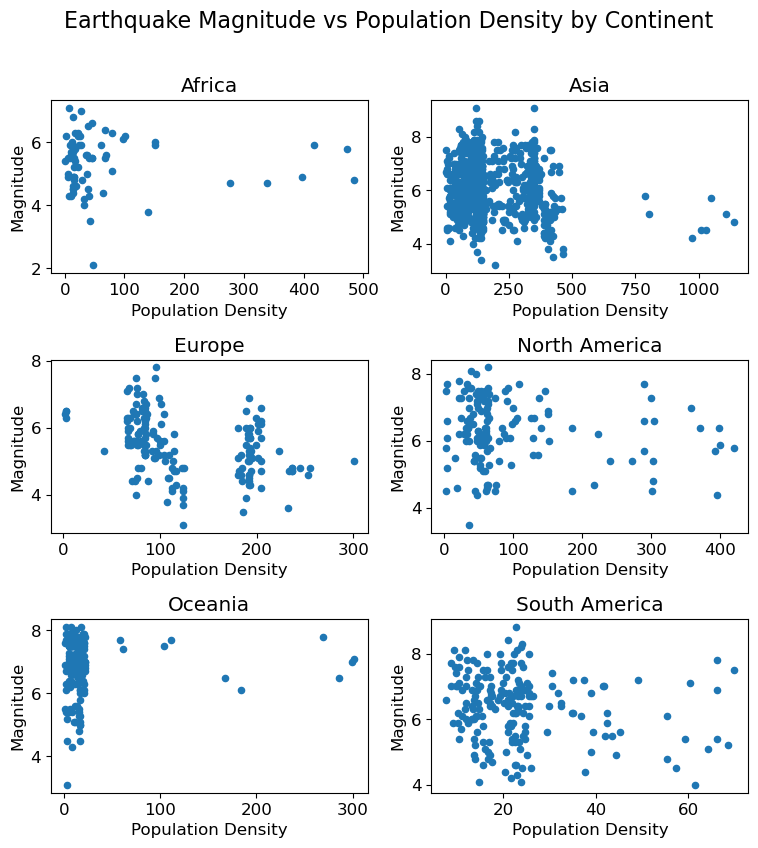

In [55]:
# Get population density of a country where an earthquake happened the same year

# load API_EN.POP.DNST_DS2_en_excel_v2_5113872 from https://data.worldbank.org/indicator/EN.POP.DNST?end=2020&start=2020&view=map
df_pop_den = pd.read_excel('API_EN.POP.DNST_DS2_en_excel_v2_5113872.xls', skiprows=3)
df['Country'] = df['Location Name'].str.split(':|;', expand=True)[0]
df_country = df[['Country', 'Mag', 'Year']]
# make country name capital letters
df_pop_den['Country Name'] = df_pop_den['Country Name'].str.upper()
df_pop_den = df_pop_den.drop(columns=['Indicator Code'])
df_pop_den = df_pop_den.drop(columns=['Indicator Name'])
df_pop_den = df_pop_den.drop(columns=['Country Code'])

# add all columns from df_pop_den to df_country based on country name
df_country_2 = df_country.merge(df_pop_den, left_on='Country', right_on='Country Name')

df_country_2 = df_country_2.drop(columns=['Country Name'])

# convert Year entries to string and remove .0
df_country_2['Year'] = df_country_2['Year'].astype(str).str[:-2]
#display(df_country_2)

# if a row entry in the 'Year' column is not in the name of a column in df_pop_den, drop that row
df_country_2 = df_country_2[df_country_2['Year'].isin(df_pop_den.columns)]
#display(df_country_2)

#make new dataframe with columns starting from 1960
df_country_3 = df_country_2[df_country_2.columns[3:]]

# if the 'Year' is equal to a column of df_country_3 make a new column called 'Density' and set it to the value of the intersection of the 'Year' and the column
for index, row in df_country_2.iterrows():
    for column in df_country_3.columns[3:]:
        if row['Year'] == column:
            df_country_2.loc[index, 'Density'] = row[column]

# drop all columns that are not 'Country', 'Mag', 'Year', or 'Density'
df_country_2 = df_country_2.drop(columns=df_country_2.columns[3:-1])
# drop all nan values
df_country_2 = df_country_2.dropna()
display(df_country_2)

# make a scatter plot of earthquake magnitude vs population density
df_country_2.plot(x='Density', y='Mag', kind='scatter')
plt.xlabel('Population Density')
plt.ylabel('Magnitude')
plt.title('Earthquake Magnitude vs Population Density of all Countries')
plt.show()

# make a plot of earthquake magnitude vs population density by continent
df_country_2['Continent'] = df_country_2['Country'].map(df_continent.set_index('Country')['Continent'])
df_country_2 = df_country_2.dropna()
df_continents = [df_country_2[df_country_2['Continent'] == 'Africa'],
                    df_country_2[df_country_2['Continent'] == 'Asia'],
                    df_country_2[df_country_2['Continent'] == 'Europe'],
                    df_country_2[df_country_2['Continent'] == 'North America'],
                    df_country_2[df_country_2['Continent'] == 'Oceania'],
                    df_country_2[df_country_2['Continent'] == 'South America']]
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(9, 9))
for i, ax in enumerate(axes.flatten()):
    df_continents[i].plot(x='Density', y='Mag', kind='scatter', ax=ax)
    ax.set_title(df_continents[i]['Continent'].unique()[0])
    ax.set_xlabel('Population Density')
    ax.set_ylabel('Magnitude')
    fig.subplots_adjust(hspace=0.5)
fig.suptitle('Earthquake Magnitude vs Population Density by Continent', fontsize=16)


,Country,Mag,Year,Deaths,Density
15,TURKMENISTAN,7.0,2000,11.0,9.723006
207,GREECE,6.8,1962,1.0,65.540985
209,GREECE,6.3,1965,38.0,66.333072
210,GREECE,7.1,1965,6.0,66.333072
211,GREECE,6.2,1965,32.0,66.333072
...,...,...,...,...,...
4370,POLAND,3.7,2019,1.0,124.025595
4371,POLAND,3.9,2019,1.0,124.025595
4372,POLAND,3.1,2019,3.0,124.025595
4374,MOZAMBIQUE,7.0,2006,4.0,26.368908


Accuracy:  0.08666666666666667
For a magnitude of 6.5 in 2023 in China with a population density of 100 people per square kilometer:
Predicted Deaths :  2.0


c:\Users\SiBuX\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


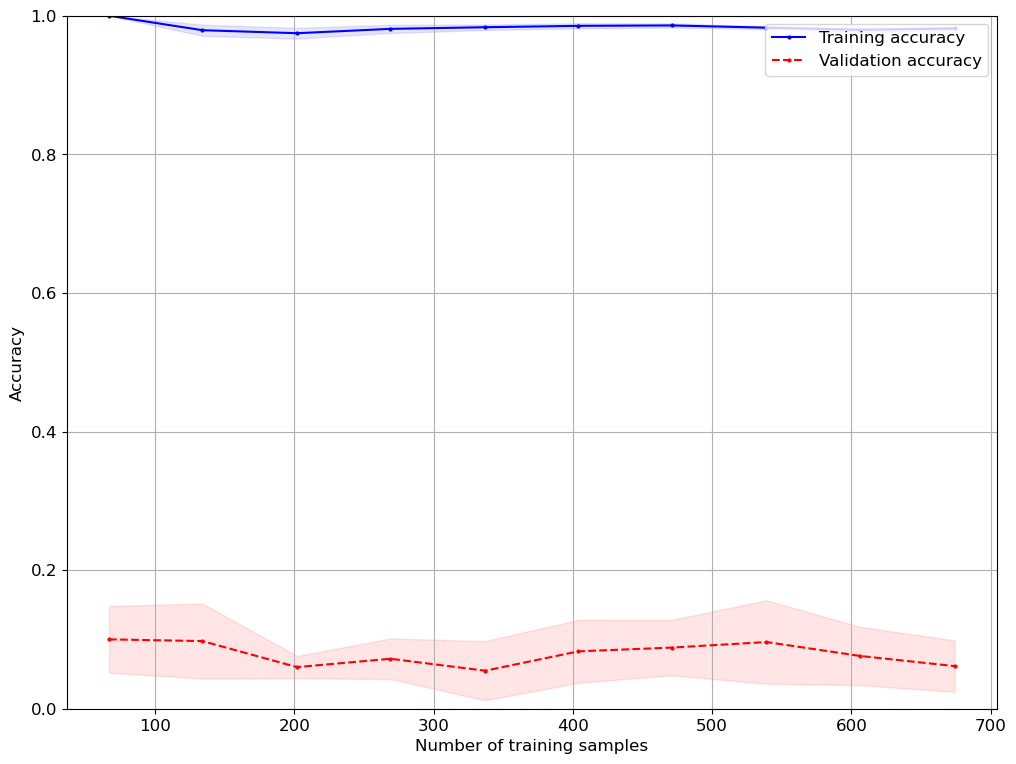

In [57]:
# Import necessary libraries
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn import tree
from sklearn.model_selection import learning_curve

def classifiy_earthquakes(feature_to_predict):
    df_pop_den = pd.read_excel('API_EN.POP.DNST_DS2_en_excel_v2_5113872.xls', skiprows=3)
    df['Country'] = df['Location Name'].str.split(':|;', expand=True)[0]
    df_country = df[['Country', 'Mag', 'Year', feature_to_predict]]
    # make country name capital letters
    df_pop_den['Country Name'] = df_pop_den['Country Name'].str.upper()
    df_pop_den = df_pop_den.drop(columns=['Indicator Code'])
    df_pop_den = df_pop_den.drop(columns=['Indicator Name'])
    df_pop_den = df_pop_den.drop(columns=['Country Code'])
    # add all columns from df_pop_den to df_country based on country name
    df_country_2 = df_country.merge(df_pop_den, left_on='Country', right_on='Country Name')
    df_country_2 = df_country_2.drop(columns=['Country Name'])
    # convert Year entries to string and remove .0
    df_country_2['Year'] = df_country_2['Year'].astype(str).str[:-2]
    # if a row entry in the 'Year' column is not in the name of a column in df_pop_den, drop that row
    df_country_2 = df_country_2[df_country_2['Year'].isin(df_pop_den.columns)]

    #make new dataframe with columns starting from 1960
    df_country_3 = df_country_2[df_country_2.columns[3:]]

    # if the 'Year' is equal to a column of df_country_3 make a new column called 'Density' and set it to the value of the intersection of the 'Year' and the column
    for index, row in df_country_2.iterrows():
        for column in df_country_3.columns[3:]:
            if row['Year'] == column:
                df_country_2.loc[index, 'Density'] = row[column]

    # drop all columns that are not 'Country', 'Mag', 'Year', or 'Density' or x
    df_country_2 = df_country_2.drop(columns=df_country_2.columns[4:-1])
    df_country_2 = df_country_2.dropna()
    display(df_country_2)

    data = df_country_2

    X = data.drop(feature_to_predict, axis=1)
    y = data[feature_to_predict]

    X = pd.get_dummies(X, columns=['Country'], prefix='c')

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    clf = DecisionTreeClassifier()

    #plot the decision tree
    clf = clf.fit(X_train, y_train)
    # plt.figure(figsize=(15, 10))
    # tree.plot_tree(clf, filled=True)
    # plt.show()

    y_pred = clf.predict(X_test)

    def selected_country(country):
        cl = X.iloc[:1, X.columns.str.startswith('c_')].copy()
        cl = cl.reset_index(drop=True)
        cl = cl.replace(1, 0)
        country = 'c_' + country
        cl[country] = 1
        return cl

    # print accuracy
    print("Accuracy: ", accuracy_score(y_test, y_pred))
    # print(clf.predict(X_test))

    # test the model and include Mag, Year, Density and features
    test = pd.DataFrame({'Mag': [6.5], 'Year': [2023], 'Density': [100]})
    test = pd.concat([test, selected_country('CHINA')], axis=1)
    print("For a magnitude of 6.5 in 2023 in China with a population density of 100 people per square kilometer:")
    print("Predicted", feature_to_predict,": ", clf.predict(test)[0])

    train_sizes, train_scores, test_scores = learning_curve(clf, X, y, cv=10, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

    # Calculate the mean and standard deviation of the training and validation scores
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    # Plot the learning curve
    plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=2, label='Training accuracy')
    plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.1, color='blue')
    plt.plot(train_sizes, test_mean, color='red', linestyle='--', marker='o', markersize=2, label='Validation accuracy')
    plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.1, color='red')
    plt.grid()
    plt.xlabel('Number of training samples')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper right')
    plt.ylim([0.0, 1.0])
    plt.show()

classifiy_earthquakes(feature_to_predict='Deaths')

# # make confusion_matrix dataframe and print it
# print(confusion_matrix(y_test, y_pred))


In [59]:
data = df_c

In [60]:
data_dropna = data.copy()
data_dropna.dropna(subset=['Year',
              'Mo',
              'Dy',
              'Hr',
              'Latitude',
              'Longitude',
              'Focal Depth (km)',
              'Mag',
              'Deaths'], inplace=True)
print(data_dropna.shape)
data_dropna.head()

(1345, 38)


,Year,Mo,Dy,Hr,Mn,Sec,Tsu,Vol,Location Name,Latitude,...,Total Missing,Total Missing Description,Total Injuries,Total Injuries Description,Total Damage ($Mil),Total Damage Description,Total Houses Destroyed,Total Houses Destroyed Description,Total Houses Damaged,Total Houses Damaged Description
307,1042.0,11.0,4.0,13.0,30.0,NaN,NaN,NaN,IRAN: TABRIZ,38.100,...,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN
630,1511.0,3.0,26.0,14.0,30.0,NaN,157.0,NaN,"BALKANS NW: SLOVENIA: IDRIJA,SKOFJA LOKA",46.200,...,NaN,NaN,NaN,NaN,NaN,3.0,NaN,3.0,NaN,NaN
737,1586.0,7.0,10.0,0.0,30.0,NaN,194.0,NaN,PERU: LIMA,-12.300,...,NaN,NaN,NaN,NaN,NaN,3.0,NaN,3.0,NaN,NaN
770,1604.0,11.0,24.0,18.0,30.0,NaN,212.0,NaN,PERU: AREQUIPA; CHILE: ARICA,-17.880,...,NaN,NaN,NaN,NaN,NaN,3.0,NaN,3.0,NaN,NaN
817,1619.0,2.0,14.0,16.0,30.0,NaN,NaN,NaN,"PERU: TRUJILLO, PIURA, SANTA",-7.941,...,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN


In [61]:
def remove_outliers(data, variable, lower=-np.inf, upper=np.inf):
    """
    Input:
      data (data frame): the table to be filtered
      variable (string): the column with numerical outliers
      lower (numeric): observations with values lower than this will be removed
      upper (numeric): observations with values higher than this will be removed
    
    Output:
      a winsorized data frame with outliers removed
    """
    return data.loc[(data[variable] > lower) & (data[variable] < upper)]

def standardize_columns(data):
    '''
    Input:
      data (data frame): contains only numeric columns
    Output:
      data frame, the same data, except each column is standardized using sklearn MinMaxScaler
      to retain proper one hot encoding
    '''
    scaler = MinMaxScaler()
    standardized_data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)
    
    return standardized_data

def fill_remove_nan(data):
    '''
    # numerical data
    data['col'] = data['col'].fillna(value=0.0)
    
    # categorical data
    data['col'] = data['col'].fillna(value="No")
    '''
    data_dropna = data.copy()
    data_dropna['Tsu'] = data_dropna['Tsu'].fillna(0)
    data_dropna['Tsu'] = data_dropna['Tsu'].apply(lambda x: 1 if x != 0 else 0)
    '''
    data_dropna['Vol'] = data_dropna['Vol'].fillna(0)
    data_dropna['Vol'] = data_dropna['Vol'].apply(lambda x: 1 if x != 0 else 0)
    '''
    data_dropna.dropna(inplace=True)
    return data_dropna

def ohe(data):
    """
    One-hot-encode ordinal and nominal features.
    """
    
    '''
    cats = [
        'cat1',
        'cat2',
        'cat3',
        'cat4',
        'cat5'
    ]
    
    cat_type = CategoricalDtype(categories=cats)
    
    data['col'] = data['col'].astype(cat_type)
    data = pd.get_dummies(data,
                          prefix='prefic',
                          columns=['col'], 
                          drop_first=True)
    '''
    data = pd.get_dummies(data,
                          prefix='tsu',
                          columns=['Tsu'], 
                          drop_first=True)
    
    '''
    data = pd.get_dummies(data,
                          prefix='vol',
                          columns=['Vol'], 
                          drop_first=True)
    '''

    return data

def select_columns(data, *columns):
    return data.reindex(columns = columns)

def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_out = df.loc[(df[column] > lower_bound) & (df[column] < upper_bound)]
    return df_out

In [62]:
def process_data(data):
    
    y_col = 'Damage ($Mil)'
    
    data = (
        data
        # Clean Data
        .pipe(remove_outliers, 'Year', lower=1960)
        #.pipe(remove_outliers, 'Damage ($Mil)', upper=550)
        
        # Transform data
        .pipe(select_columns, 
                'Year',
                'Mo',
                'Dy',
                'Hr',
                'Tsu',
                #'Vol',
                'Focal Depth (km)',
                'Mag',
                y_col
            )
        #.pipe(ohe)
        .pipe(fill_remove_nan)
        .pipe(remove_outliers_iqr, y_col)
        #.pipe(ohe)
    ) 

    
     # Return predictor and response variables separately
    X = standardize_columns(data).drop([y_col], axis = 1) # need to decide target feature y
    y = data[y_col]
    
    return X, y

In [63]:
np.random.seed(22334)

In [64]:
train, test = train_test_split(data, test_size=0.2)

# Pre-process our training and test data in exactly the same way
# Our functions make this very easy!
X_train, y_train = process_data(train)
X_test, y_test = process_data(test)
model = lm.LinearRegression(fit_intercept=True)

model.fit(X_train, y_train)
y_fitted = model.predict(X_train)
y_predicted = model.predict(X_test)

In [65]:
print(y_fitted.mean())
print(y_predicted.mean())

78.65288925081433
97.16734107489279


Text(0, 0.5, 'Residuals (Actual Damage - Predicted Damage)')

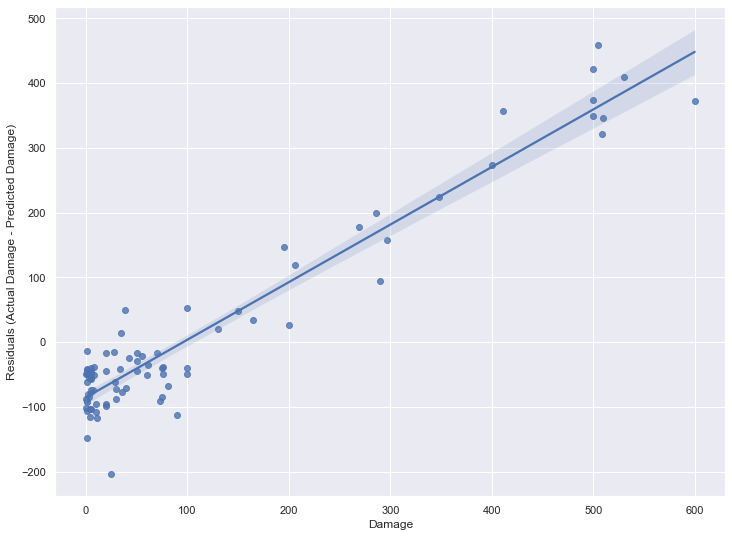

In [66]:
residuals = y_test - y_predicted
ax = sns.regplot(x=y_test, y=residuals)
ax.set_xlabel('Damage')
ax.set_ylabel('Residuals (Actual Damage - Predicted Damage)')

In [67]:
from sklearn.metrics import r2_score
r2_score(y_test, y_predicted)

0.13500146616756603

Ethical Considerations

Provide Datasheets for the Dataset (see portal)
*  How did you get the data (legally...)?
*  Did you check the source?
*  Are there considerations about the analysis you made?
*  Did you have to make decisions that affect the analysis?
*  What are the limitations of your analysis and your conclusions?
*  Who are the stakeholders of your project?
*  Who can benefit from this project, who can be harmed, who is excluded, etc.

(datasets, source, considerations, decisions)
Out main dataset was from the National Centers for Environmental Information (NOAA). The data on magnitudes of earthquakes, dates, location, focal depth, and coordinates was directly observable and collected by National Oceanic and Atmospheric Administration which gets its data from satellites, buoys, weather stations, and citizen scientists. The NOAA The data was collected from four main national locations, many regional centers, field sites, and cooperative institutes all over the U.S. There is no information about how the damage in terms of currency was estimated or how the deaths were found. NOAA works with weather stations around the world to collect seismological data. Additionally, they used buoys in combination with satellites and weather stations to determine if Tsunamis were caused by the corresponding earthquakes. The Significant Earthquake database’s origin comes from the Significant Earthquake Catalog made in 1981 by Ganse, Robert A., John B. Nelson. The dataset is an expansion of the World Map of Significant Earthquakes 1900 to 1979. The sampling strategy was deterministic. The data collection process is done mostly by workers and scientists funded by the NOAA.  The NOAA 2022 funding is around $15,000,000 a year with the highest awards ranging up to $300,000 a year. The timeframe of the data collection is From 2150 B.C. to 2023. In January 2021 U.S. President Biden issued a Memorandum to ensure Scientific Integrity and Evidence-Based Policymaking which NOAA’s Scientific Integrity Policy is compliant with. The NOAA is continuously updating is compliance policy as appropriate. This dataset was obtained legally as it is publicly available for anyone to use on the NOAA website. 

An additional dataset was used and merged with the main one which contained information about average population densities for countries around the world from 2020. The Source of this data is the Food and Agriculture Organization and World Bank population estimates. This dataset is available to the public from the World Banks official website and was obtained legally. The population density was calculated by taking the midyear population of a country and dividng by the land area in square kilometers. The definition of population included all residents regardless of legal status or citizenship, however exculded refugees not permanently settles in the country of asylum. The land area was defined as the countries total inland area excluding land with bodies of water such as lakes and rivers.

(stakeholders)
The stakeholders of this projects would be governments or anyone interested in predicting the potential harm an earthquake could do as an initial estimate to know what kind of threats a city or country is facing such as number of deaths. For example, if an earthquake happens the government or anyone could input the magnitude, country, year and density of city to get a rough idea of possible damages or deaths that could occurr. This could potentially allow for better judgement as to what emergency services to finance and general expectations to have.

(conclusions and limitation)
In the end we are able to predict the possible Deaths depending on the magnitude and the density of a given country relatively well using a Decision Tree Classifier, however the accuracy of the prediction is quite low due to the low number of row entries after droping values that are NaN. Further dataset could be investigated and merged with our main dataset to fill in these values. Additionally we could merge more features based on current values to also create more row entries to allow our model to be more accurate.
(something about regression here too)
